# jsats3D Project Notebook
jsats3d was developed by Kleinschmidt to assist researchers with cleaning and managing small scale acoustic telemetry studies (<1000 tagged individuals, <20 receivers)  The resulting dataset represents a standardized, repeatable and defensible product.  This notebook guides users through every task one may have when preparing acoustic telemetry data for least squares positioning, including: creating a standardized technology agnostic project database, importing raw data directly from receiver downloads, identifying and removing multipath, synchronizing clocks, and positioning receivers at depth in 3D space.  Future Notebooks will allow users to  visualize resultant point clouds with kernel density functions.  

Acoustic telemetry projects create vast quantities of data.  To handle the amount of data generated by these projects, jsats3d relies on a SQLite project database.  SQLite is an in-process library that implements a self-contained, server-less, zero configuration, transactional SQL database engine (SQLite, 2017).  More importantly, SQLite can handle simultaneous reads, so it is well-suited for write-once, read-many largescale data analysis projects that employ parallel processing across multiple cores.  To view the SQLite project database download either: [sqlite browser](http://sqlitebrowser.org/) or [sqlite studio](https://sqlitestudio.pl/index.rvt) .  Both SQLite viewers can execute SQL statements, meaning you can create a query and export to csv file from within the database viewer.  They are not that different from Microsoft Access, users familiar with databases will have an easy transition into SQLite.

The software is written in Python 3.7.x and uses dependencies outside of the standard packages.  Please make sure you have the following modules installed and updated when running telemetry analysis: Numpy, Pandas, Networkx, Matplotlib, Sqlite3, Statsmodels, and SciKit Learn.  The software also uses a number of standard packages including: Time, Math, Os, Datetime, Operator, and Collections.  

The project notebook will guide the end user through a coplete acoustic telemetry project.  However, you could import jsats3d into your own proprietary scripts and data management routines.  The provided scripts and notebooks are examples only and represent current best practices.

---

# Project Set Up

## Supporting Python Modules
jsats3d can't do it alone, we need other libraries to assist with data I/O, analysis, and visualization.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import sqlite3
from scipy.interpolate import interp1d

In [2]:
#%matplotlib ipympl

up to you, but you can supress warnings by running the following cell

In [3]:
import warnings
warnings.filterwarnings('ignore')

---

## Connecting to and using jsats3d
The author of this notebook recommends users clone jsats3d into a local directory of their choosing.  

In [4]:
jsats_dir = r"C:\Users\knebiolo\OneDrive - Kleinschmidt Associates, Inc\Software\jsats3d"
sys.path.append(jsats_dir)
import jsats3d

---

## Identify Project Parameters and Create a Project Workspace
Important project parameters include input workspaces for raw data and final data products and software output.  Parameters also include a database name, conversion from UTC to the local timezone, a benchmark elevation in meters, a master receiver used for time keeping, the coordinate system describing surveyed points, a project syncronization time, and a project end time.  

**The project syncronization time is a critical parameter.  It is the moment the master receiver clock was syncronized to UTC - aka GPS time.**

In [5]:
utc_conv = -7                           # hours from UTC to local
bm_elev = 861.5/3.28084                 # benchmark elevation
bm_elev_units = 'meters'                # elevation units
masterReceiver = 'R05'                  # identify the master receiver -aka the study metronome
metronome = 'FF75'                      # identify the beacon tag associated with the metronome receiver
EPSG = 26910                            # coordinate system 
output_units = 'meters'                 # output units
synch_start_time = "2018-06-07 14:09"   # study synchronization time
synch_time_end = "2018-08-09 10:30"     # study end time


Before proceeding to the next step, the end user of this notebook needs to identify the project directory.  Then the Notebook will create the following folder structure:

* Project_Name
    * Data *for storing raw data and project set up files*
	* Output *for storing figures, modeling files, and scratch data*
	    * Scratch *holds intermediate files that are managed by the software* 
		* Figures *holds figures exported by the software*

**Do not alter the structure of the directory.** The notebook expects the project directory is structured exactly as depicted.

First, identify the project's directory:

In [6]:
proj_dir = r"C:\Users\knebiolo\Desktop\jsats with DBSCAN"

Then, create a standard jsats3d project directory **If you are working on a fresh kernel and want to use your saved data, do not run the next cell.** 

In [7]:
#os.mkdir(os.path.join(proj_dir,'Data'))
#os.mkdir(os.path.join(proj_dir,'Output'))
#os.mkdir(os.path.join(proj_dir,'Output','Scratch'))
#os.mkdir(os.path.join(proj_dir,'Output','Figures'))

Now we need to connect the project workspace to this notebook. 

In [8]:
inputWS = os.path.join(proj_dir,"Data")
outputWS = os.path.join(proj_dir,"Output")

---

## Create a Project Database
the following commands will create a manufacturer agnostic project database

In [9]:
dbName = 'cowlitz_test3.db'            # give your project a name
dbDir = os.path.join(outputWS,dbName)

Sometimes you need to come back to the project to finish positioning.  **If you are working on a fresh kernel and want to use your saved data, do not run the next cell.** 

In [ ]:
#jsats3d.create_project_db(outputWS, dbName) # create project database

---

## Master Receiver Table
The receiver file must contain the following fields and should be saved as a comma delimited text file in the project Data folder.  Please see the schema below.  Please save the master receiver file to the ‘Data’ folder.    A good name for this file is “tblReceiver.csv”.  Note, the Z coordinate is optional because it may be impractical to accurately measure receivers at depth.

| Field      | Data Type |                                      Comment                             |
|------------|-----------|--------------------------------------------------------------------------|
|Rec_ID      |String     |(required) - unique alphanumeric receiver ID                              |
|Type        |String     |(required) - receiver make and model                                      |
|Tag_ID      |String     |(required) - alphanumeric ID for receiver's beacon tag                    |
|Ref_Elev    |String     |(required) - receivers either relative to 'WSEL' or 'BM'                  |
|X           |Float      |(required) - X surveyed coordinate of receiver in study EPSG              |
|Y           |Float      |(required) - Y surveyed coordinate of reciever in study EPSG              |
|Z           |Float      |(optional) - Z surveyed coordinate of receiver in study Vertical Datum    |
|X_t         |Float      |(required) - transformed X coordinate into local datum                    |
|Y_t         |Float      |(required) - transformed Y coordinate into local datum                    |
|Z_t         |Float      |(optional) - transformed Z coordinate into local datum                    |

Import the receiver table and write it to the project database

In [ ]:
jsats3d.study_data_import(pd.read_csv(os.path.join(inputWS,'tblReceiver.csv')),dbDir,'tblReceiver')  

---

## Master Tag Table
The master tag file contains a list of all active acoustic tags in the project and the table must contain the following fields and should be saved as a comma delimited text file in the project Data folder. 

Please name the file  “tblTag.csv” and save in the project's Data folder.  

Please see the schema below. 

| Field      | Data Type |                                      Comment                             |
|------------|-----------|--------------------------------------------------------------------------|
|Tag_ID      |String     |(required) - unique alphanumeric tag ID                                   |
|pulseRate   |Float      |(required) - tag burst rate in decimal seconds                            |
|TagType     |String     |(required) - a tag can either be 'study' or 'beacon'                      |


In [ ]:
jsats3d.study_data_import(pd.read_csv(os.path.join(inputWS,'tblTag.csv')),dbDir,'tblTag')

---
## Import Water Surface Elevation

Three of the receivers in the original source study tracked with water surface elevation or WSEL.  Therefore, it was necessary to obtain operations data that tracked WSEL in time.  

The WSEL file for use in jsats3d must contain the following fields:

| Field      | Data Type |                                      Comment                             |
|------------|-----------|--------------------------------------------------------------------------|
|timeStamp   |String     |(required) - date time precise to the decimal second                      |
|WSEL        |Float      |(required) - water surface elevation in project's vertical datum          |

In [ ]:
jsats3d.study_data_import(pd.read_csv(os.path.join(inputWS,'tblWSEL.csv'), parse_dates = True),dbDir,'tblWSEL')

Write Study Parameters to Database

In [ ]:
jsats3d.set_study_parameters(utc_conv,
                             bm_elev,
                             bm_elev_units,
                             output_units,
                             masterReceiver,
                             synch_start_time,
                             synch_time_end,dbDir)

---
## Import Raw Data
The data generated by the source project was managed with separate directories for each receiver.  jsats3d imports data for a single receiver at a time.  

The function acoustic_data_import requires the end user to declare the Receiver ID, Receiver Type, data directory, and database directory

In [ ]:
jsats3d.acoustic_data_import('R01','Teknologic',os.path.join(inputWS, "Raw","R01"),dbDir)  #R01
jsats3d.acoustic_data_import('R02','Teknologic',os.path.join(inputWS, "Raw","R02"),dbDir)  #R02
jsats3d.acoustic_data_import('R03','Teknologic',os.path.join(inputWS, "Raw","R03"),dbDir)  #R03
jsats3d.acoustic_data_import('R04','Teknologic',os.path.join(inputWS, "Raw","R04"),dbDir)  #R04
jsats3d.acoustic_data_import('R05','Teknologic',os.path.join(inputWS, "Raw","R05"),dbDir)  #R05
jsats3d.acoustic_data_import('R06','Teknologic',os.path.join(inputWS, "Raw","R06"),dbDir)  #R06
jsats3d.acoustic_data_import('R07','Teknologic',os.path.join(inputWS, "Raw","R07"),dbDir)  #R07
jsats3d.acoustic_data_import('R08','Teknologic',os.path.join(inputWS, "Raw","R08"),dbDir)  #R08
jsats3d.acoustic_data_import('R09','Teknologic',os.path.join(inputWS, "Raw","R09"),dbDir)  #R09
print ("Data Import Complete")

---
## Temperature at t
In fresh water, sound travels faster than 1 km per second and is affected by temperature.  The warmer the temperature, the faster the speed of sound.  Unfortunately, an acoustic pulse from a tag may travel through a stratified water column, changing velocity as it approaches the receiver.  A variable speed of sound means positional accuracy will be reduced.  The source study collected continuous temperature observations at three locations.  At each location, the entire water column was sampled with TidBit temperature sensors deployed every meter.  The temperature at t used to determine the speed-of-sound at t, is the mean of all observed temperatures at t.  The following code imports temperature data structured in the table below.  Your project will likely be different, so it is be adviseable to amend this code as needed. At the end of the day, jsats3d requires a 'tblInterpolatedTemp', aka temperature at t, to work. 

| Field      | Data Type |                                      Comment                             |
|------------|-----------|--------------------------------------------------------------------------|
|location    |String     |(required) - location wihtin study area                                   |
|depth_ft    |Float      |(required) - depth of temperature sensor                                  |
|meas_dt     |DateTime   |(required) - a date and time of temperature reading                       |
|temp_f      |Float      |(required) - a temperature reading in Farhenheight                        |

First, get some data, and do some basic data management to get things in metric

In [ ]:
temp = pd.read_csv(os.path.join(inputWS,"tblTemp.csv"))
temp['time_stamp'] = pd.to_datetime(temp.meas_dt)
temp['loc_dep_id'] = temp.location + "-" + temp.depth_ft.astype(np.str)
temp['temp_celcius'] = (temp.temp_f - 32.) * 5./9.
temp['depth_m'] = np.round(temp.depth_ft / 3.28084, 2)

Next, create a linear interpolator for each depth/location pair

In [ ]:
locs = temp.loc_dep_id.unique()
locDat = dict()
locLinearInterp = dict()
locEpochMin = dict()
locEpochMax = dict()
for i in locs:
    loc_dat = temp[temp.loc_dep_id ==i]
    loc_dat.sort_values('time_stamp', inplace = True)
    loc_dat['seconds'] = loc_dat.time_stamp.astype(np.int64)/1.0e9
    loc_dat.drop_duplicates('seconds',keep = 'first',inplace = True)
    loc_dat.set_index('seconds',inplace = True,drop = False)
    loc_dat.dropna(inplace = True)
    print ("Location %s data from %s through %s"%(i,loc_dat.time_stamp.min(),loc_dat.time_stamp.max()))
    locDat[i] = loc_dat
    locLinearInterp[i] = interp1d(loc_dat.seconds.values,loc_dat.temp_celcius.values,kind = 'linear',bounds_error = False,fill_value = np.nan)
    locEpochMin[i] = loc_dat.seconds.min()
    locEpochMax[i] = loc_dat.seconds.max()

Now interpolate the mean temperature 

In [ ]:
epochMin = min(locEpochMin.values())-0.100000
epochMax = max(locEpochMax.values())+0.100000
linear_temps = []
epoch_range = np.linspace(epochMin,epochMax,10000)
ts = pd.to_datetime(epoch_range,unit = 's')
for i in epoch_range:
    temps = []
    for j in locLinearInterp:
        temps.append(locLinearInterp[j](i))
    linear_temps.append(np.nanmean(temps))

Plot temperatures and examine

In [ ]:
xfmt = mdates.DateFormatter('%m-%d')
fig = plt.figure(figsize = (10,6))
plt.xticks(rotation = 45)
ax = fig.add_subplot(111)
ax.plot_date(temp[(temp.location == 'A') & (temp.depth_m == np.round(1.64 / 3.28084, 2))].time_stamp.values,temp[(temp.location == 'A') & (temp.depth_m == np.round(1.64 / 3.28084, 2))].temp_celcius.values,linestyle = '-', label = r'%s m'%(np.round(1.64 / 3.28084, 2)), color = '#ADD8E6',ms = 0.1)
ax.plot_date(temp[(temp.location == 'A') & (temp.depth_m == np.round(4.92 / 3.28084, 2))].time_stamp.values,temp[(temp.location == 'A') & (temp.depth_m == np.round(4.92 / 3.28084, 2))].temp_celcius.values,linestyle = '-',label = r'%s m'%(np.round(4.92 / 3.28084, 2)), color = '#87CEFA',ms = 0.1)
ax.plot_date(temp[(temp.location == 'A') & (temp.depth_m == np.round(9.84 / 3.28084, 2))].time_stamp.values,temp[(temp.location == 'A') & (temp.depth_m == np.round(9.84 / 3.28084, 2))].temp_celcius.values,linestyle = '-',label = r'%s m'%(np.round(9.84 / 3.28084, 2)), color = '#6495ED',ms = 0.1)
ax.plot_date(temp[(temp.location == 'A') & (temp.depth_m == np.round(14.76 / 3.28084, 2))].time_stamp.values,temp[(temp.location == 'A') & (temp.depth_m == np.round(14.76 / 3.28084, 2))].temp_celcius.values,linestyle = '-',label = r'%s m'%(np.round(14.76 / 3.28084, 2)), color = '#4169E1',ms = 0.1)
ax.plot_date(temp[(temp.location == 'A') & (temp.depth_m == np.round(19.69 / 3.28084, 2))].time_stamp.values,temp[(temp.location == 'A') & (temp.depth_m == np.round(19.69 / 3.28084, 2))].temp_celcius.values,linestyle = '-',label = r'%s m'%(np.round(19.69 / 3.28084, 2)), color = '#0000FF',ms = 0.1)
ax.plot_date(temp[(temp.location == 'A') & (temp.depth_m == np.round(24.61 / 3.28084, 2))].time_stamp.values,temp[(temp.location == 'A') & (temp.depth_m == np.round(24.61 / 3.28084, 2))].temp_celcius.values,linestyle = '-',label = r'%s m'%(np.round(24.61 / 3.28084, 2)), color = '#0000CD',ms = 0.1)
ax.plot_date(temp[(temp.location == 'A') & (temp.depth_m == np.round(29.53 / 3.28084, 2))].time_stamp.values,temp[(temp.location == 'A') & (temp.depth_m == np.round(29.53 / 3.28084, 2))].temp_celcius.values,linestyle = '-',label = r'%s m'%(np.round(29.53 / 3.28084, 2)), color = '#00008B',ms = 0.1)
ax.plot_date(temp[(temp.location == 'A') & (temp.depth_m == np.round(39.37 / 3.28084, 2))].time_stamp.values,temp[(temp.location == 'A') & (temp.depth_m == np.round(39.37 / 3.28084, 2))].temp_celcius.values,linestyle = '-',label = r'%s m'%(np.round(39.37 / 3.28084, 2)), color = '#000080',ms = 0.1)
ax.plot_date(temp[(temp.location == 'A') & (temp.depth_m == np.round(47.57 / 3.28084, 2))].time_stamp.values,temp[(temp.location == 'A') & (temp.depth_m == np.round(47.57 / 3.28084, 2))].temp_celcius.values,linestyle = '-',label = r'%s m'%(np.round(47.57 / 3.28084, 2)), color = '#191970',ms = 0.1)
ax.plot_date(ts,linear_temps, 'r-', label = r'linear',lw = 1)
ax.xaxis.set_major_formatter(xfmt)
ax.set_ylim(5,25)
plt.legend(loc = 2)
ax.set_ylabel('Celsius')
plt.xticks(rotation = 45, fontsize = 7)
plt.show()


Create a pandas dataframe of interpolated mean temperature (aka temp at t) and write to project database

In [ ]:
df_dict = {'timeStamp':ts,'C':linear_temps}
temp_df = pd.DataFrame.from_dict(df_dict,orient = 'columns')
temp_df.head()
conn = sqlite3.connect(os.path.join(outputWS,dbName), timeout = 30.0)
c = conn.cursor
temp_df.to_sql('tblInterpolatedTemp',con = conn, if_exists = 'replace')


---

# Enumerate Metronome Beacon Tag Transmissions (Epochs)

When you started the project, one of the parameters identifies the project's metronome.  The beacon tag attached to this receiver will serve as the temporal datum for the project.  Each beacon tag transmission is a new epoch.  Essentially, jsats3d starts counting beacon transmissions the second the metronome is synchronized with UTC.

In [ ]:
# create a metronome data object
metronome_dat = jsats3d.beacon_epoch(metronome,dbDir,outputWS) 

Enumerate epochs at metronome and adjacent receivers

In [ ]:
# enumerate epochs at the metronome receiver
metronome_dat.host_receiver_enumeration() 
# enumerate epoch transmissions at all other receivers
metronome_dat.adjacent_receiver_enumeration()    


Primary Multipath Filter

In [ ]:
metronome_multipath = jsats3d.multipath_data_object(metronome,dbDir,outputWS,metronome = True) 
jsats3d.multipath_2(metronome_multipath)

Secondary Multipath Filter

Generate training and testing datasets
Accuracy for the R01 KNN was: 0.9990672817565354
Precision for the R01 KNN was: 1.0
Recall for the R01 KNN was: 0.997020454179417


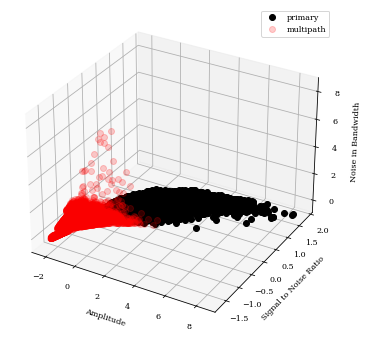

Generate training and testing datasets
Accuracy for the R02 KNN was: 0.9992917109347332
Precision for the R02 KNN was: 0.9997356071121687
Recall for the R02 KNN was: 0.998020455295282


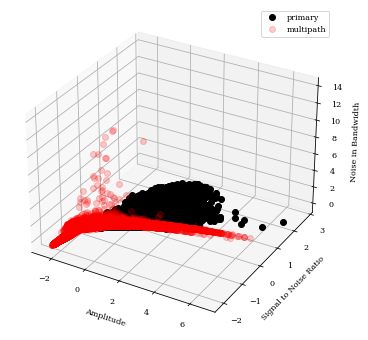

Generate training and testing datasets
Accuracy for the R03 KNN was: 0.9994846423417852
Precision for the R03 KNN was: 1.0
Recall for the R03 KNN was: 0.9982833207443521


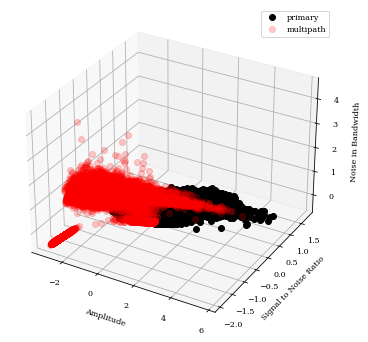

Generate training and testing datasets
Accuracy for the R04 KNN was: 0.9991435300835059
Precision for the R04 KNN was: 1.0
Recall for the R04 KNN was: 0.9828326180257511


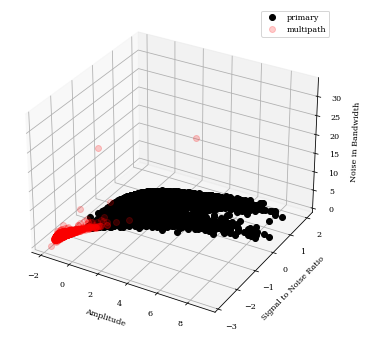

Generate training and testing datasets
Accuracy for the R06 KNN was: 0.999795207864018
Precision for the R06 KNN was: 1.0
Recall for the R06 KNN was: 0.9982658959537573


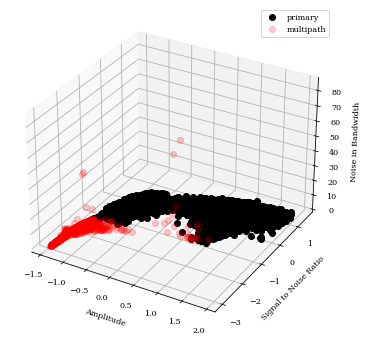

Generate training and testing datasets
Accuracy for the R07 KNN was: 0.9971005646268885
Precision for the R07 KNN was: 0.9917582417582418
Recall for the R07 KNN was: 0.9575596816976127


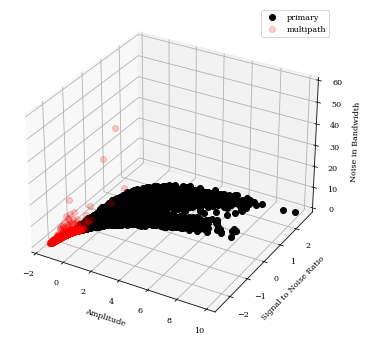

Generate training and testing datasets
Accuracy for the R08 KNN was: 0.8966017071992269
Precision for the R08 KNN was: 0.639751552795031
Recall for the R08 KNN was: 0.3412856196156395


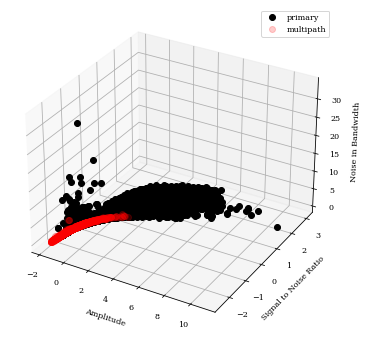

Generate training and testing datasets
Accuracy for the R09 KNN was: 0.9398390599054797
Precision for the R09 KNN was: 0.6078431372549019
Recall for the R09 KNN was: 0.3463687150837989


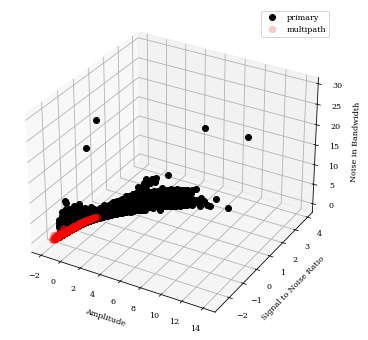

In [10]:
jsats3d.multipath_classifier(metronome,dbDir,os.path.join(outputWS,'Scratch'),metronome = True, method = 'KNN')
jsats3d.multipath_data_management(os.path.join(outputWS,'Scratch'),dbDir,metronome = True)         # add data to database

---
# Synchronize Receivers at the surface
We do not know the locations of receivers at depth, therefore we can't synchronize them yet.  This step synchronizes the receivers at the surface.

Returned 121245 number of rows for Receiver R05 at R04
created preliminary data objects for receiver R04
Length of clock data = 44721 rows
After join, receiver dat 44674 rows long


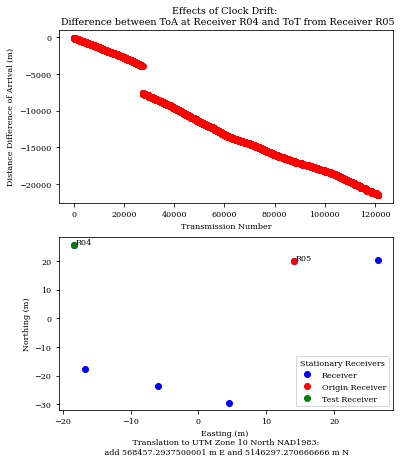

Finished Processing Receiver R04
Returned 121245 number of rows for Receiver R05 at R05
created preliminary data objects for receiver R05
Length of clock data = 0 rows
No data for receiver R05 check inputs
Finished Processing Receiver R05
Returned 121245 number of rows for Receiver R05 at R06
created preliminary data objects for receiver R06
Length of clock data = 43889 rows
After join, receiver dat 43869 rows long


<Figure size 432x288 with 0 Axes>

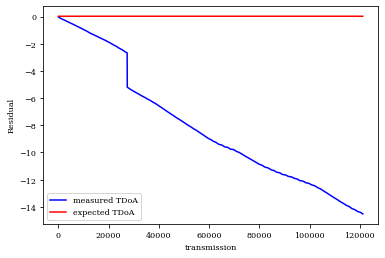

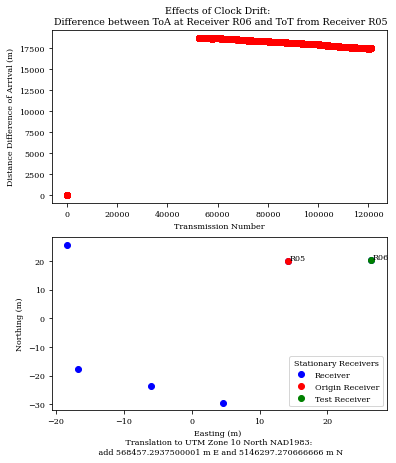

Finished Processing Receiver R06
Returned 121245 number of rows for Receiver R05 at R07
created preliminary data objects for receiver R07
Length of clock data = 42790 rows
After join, receiver dat 42762 rows long


<Figure size 432x288 with 0 Axes>

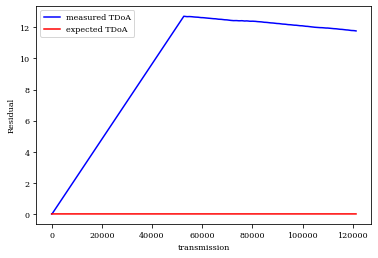

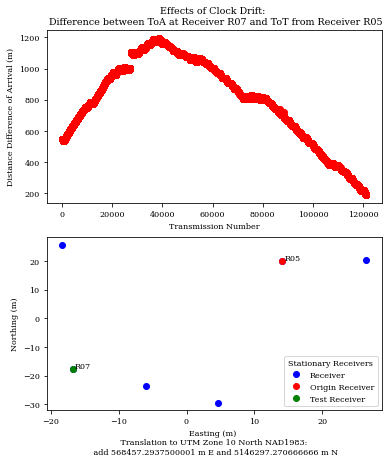

Finished Processing Receiver R07
Returned 121245 number of rows for Receiver R05 at R08
created preliminary data objects for receiver R08
Length of clock data = 40071 rows
After join, receiver dat 40050 rows long


<Figure size 432x288 with 0 Axes>

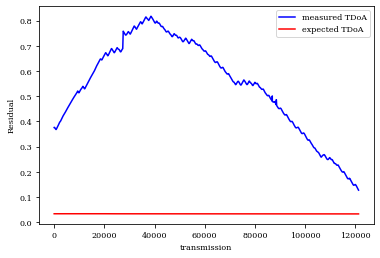

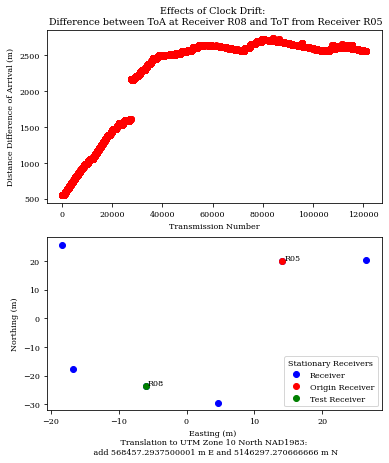

Finished Processing Receiver R08
Returned 121245 number of rows for Receiver R05 at R09
created preliminary data objects for receiver R09
Length of clock data = 26030 rows
After join, receiver dat 26010 rows long


<Figure size 432x288 with 0 Axes>

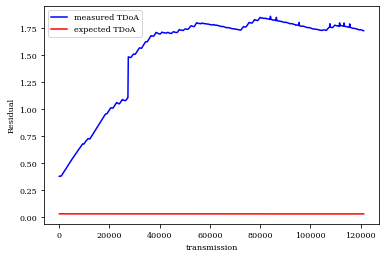

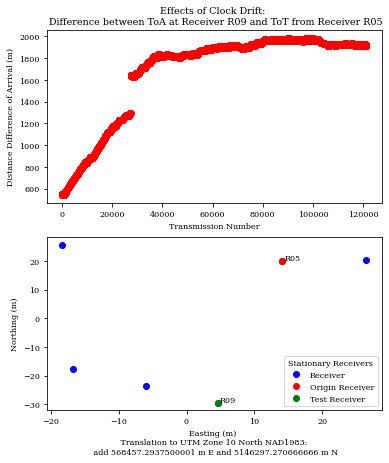

Finished Processing Receiver R09


<Figure size 432x288 with 0 Axes>

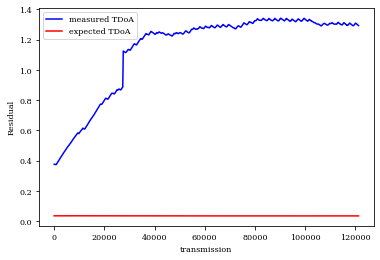

In [11]:
# list receivers at the surface and iterate
recList = ['R04','R05','R06','R07','R08','R09']
for i in recList:
    clock_fix_object = jsats3d.clock_fix_object(i,recList,dbDir,os.path.join(outputWS,'Scratch'),outputWS) 
    print ("created preliminary data objects for receiver %s"%(i))
    jsats3d.clock_fix(clock_fix_object)
    print ("Finished Processing Receiver %s"%(i))
    
jsats3d.epoch_fix_data_management(os.path.join(outputWS,'Scratch'),dbDir)


---
# Remove Multipath From Beacon Transmissions
It is possible that the beacon tag transmissions from the receivers at depth that were detected at the surface receivers were the result multipath.  This next cell identifies and removes multipath detections.  
In the source study, the receivers at depth were R01, R02, and R03.  Your study will likely have different nomenclature and you will need to amend the list of beacon tags.

In [12]:
beacons = ['FF76','FF74','FF78']
# apply primary filter
for i in beacons:
    obj = jsats3d.multipath_data_object(i,dbDir,os.path.join(outputWS,'Scratch'))                  
    jsats3d.multipath_2(obj)                                                        
    print("Primary filter applied to tag %s"%(i))

jsats3d.multipath_data_management(os.path.join(outputWS,'Scratch'),dbDir)        

Primary filter applied to tag FF76
Primary filter applied to tag FF74
Primary filter applied to tag FF78


And now a secondary classifier

Secondary mulitpath filter applied to tag FF76
Generate training and testing datasets
Accuracy for the R04 KNN was: 0.9959360857116468
Precision for the R04 KNN was: 0.9790794979079498
Recall for the R04 KNN was: 0.7381703470031545


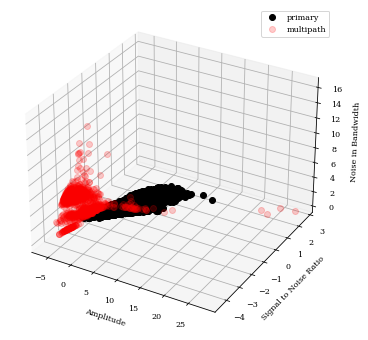

Generate training and testing datasets
Accuracy for the R06 KNN was: 0.896404109589041
Precision for the R06 KNN was: 0.6866952789699571
Recall for the R06 KNN was: 0.28021015761821366


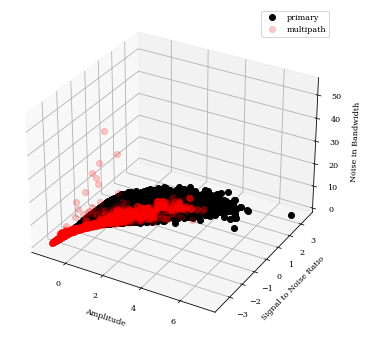

Generate training and testing datasets
Accuracy for the R07 KNN was: 0.9995817241331233
Precision for the R07 KNN was: 1.0
Recall for the R07 KNN was: 0.9991803054728271


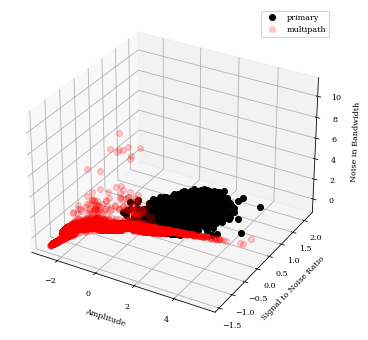

Generate training and testing datasets
Accuracy for the R08 KNN was: 0.9994930408332565
Precision for the R08 KNN was: 0.9998682650507179
Recall for the R08 KNN was: 0.9990457073283096


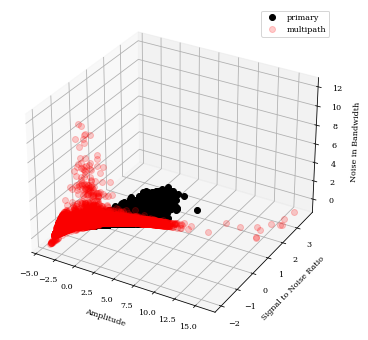

Generate training and testing datasets
Accuracy for the R09 KNN was: 0.9985270487412962
Precision for the R09 KNN was: 0.9998289721224559
Recall for the R09 KNN was: 0.997355625693082


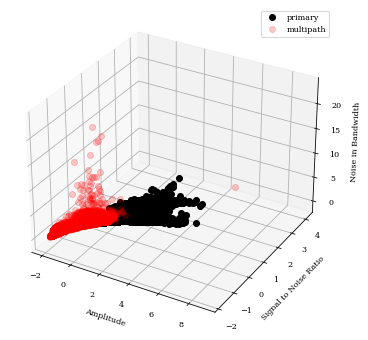

Secondary mulitpath filter applied to tag FF74
Generate training and testing datasets
Accuracy for the R04 KNN was: 0.9999855574812248
Precision for the R04 KNN was: 1.0
Recall for the R04 KNN was: 0.9999707422686445


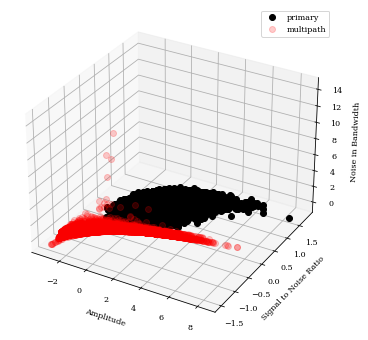

Generate training and testing datasets
Accuracy for the R06 KNN was: 0.997083485235144
Precision for the R06 KNN was: 1.0
Recall for the R06 KNN was: 0.9926820343944384


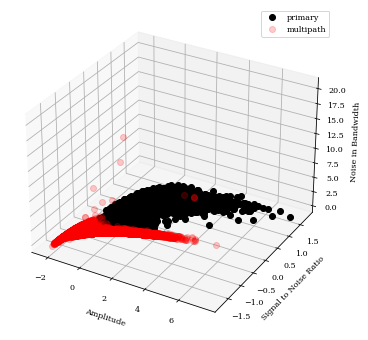

Generate training and testing datasets
Accuracy for the R07 KNN was: 0.9978329850630756
Precision for the R07 KNN was: 0.9999657756938978
Recall for the R07 KNN was: 0.9952651837721838


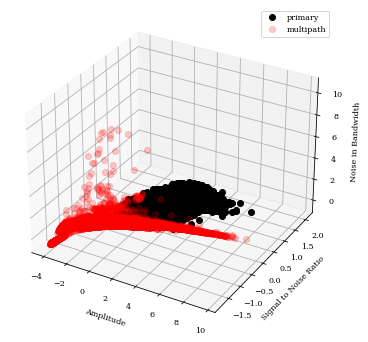

Generate training and testing datasets
Accuracy for the R08 KNN was: 0.9979155408013588
Precision for the R08 KNN was: 0.9999317825226823
Recall for the R08 KNN was: 0.9954837176135013


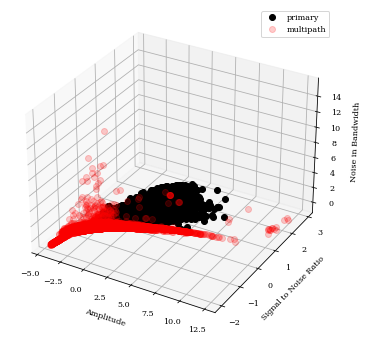

Generate training and testing datasets
Accuracy for the R09 KNN was: 0.9998071359691417
Precision for the R09 KNN was: 1.0
Recall for the R09 KNN was: 0.9997853616655935


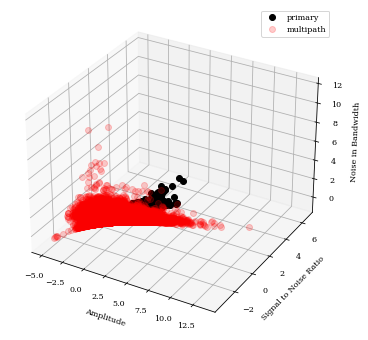

Secondary mulitpath filter applied to tag FF78
Generate training and testing datasets
Accuracy for the R04 KNN was: 0.9974333557545934
Precision for the R04 KNN was: 1.0
Recall for the R04 KNN was: 0.9936459246275198


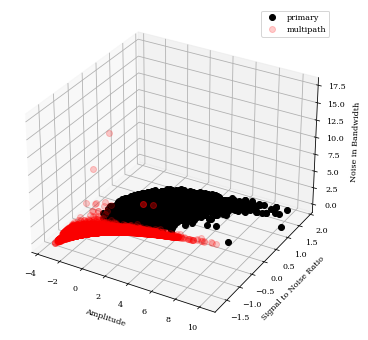

Generate training and testing datasets
Accuracy for the R06 KNN was: 0.998286203941731
Precision for the R06 KNN was: 1.0
Recall for the R06 KNN was: 0.9956228956228956


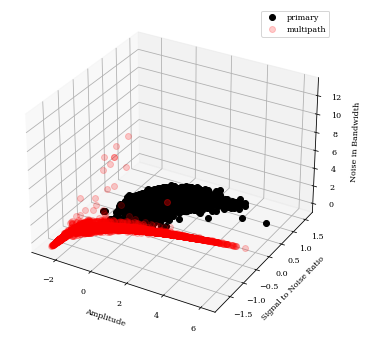

Generate training and testing datasets
Accuracy for the R07 KNN was: 0.9985254283470373
Precision for the R07 KNN was: 0.9993476606385677
Recall for the R07 KNN was: 0.9973235921733155


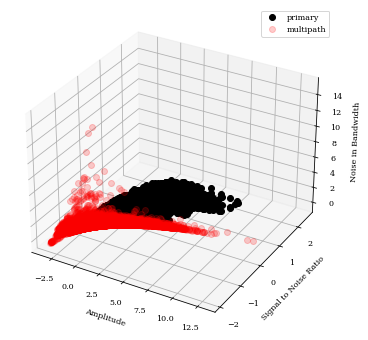

Generate training and testing datasets
Accuracy for the R08 KNN was: 0.997194308454293
Precision for the R08 KNN was: 1.0
Recall for the R08 KNN was: 0.20967741935483872


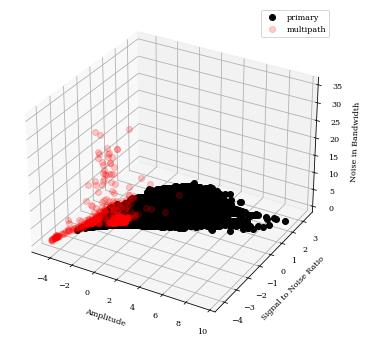

Generate training and testing datasets
Accuracy for the R09 KNN was: 0.9865391427559334
Precision for the R09 KNN was: 0.9967982924226254
Recall for the R09 KNN was: 0.9748024452065007


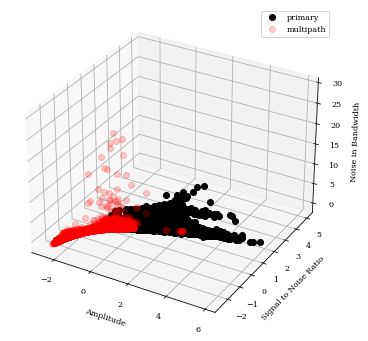

In [14]:
# apply secondary filter
for i in beacons:
    print ("Secondary mulitpath filter applied to tag %s"%(i))
    jsats3d.multipath_classifier(i,dbDir,os.path.join(outputWS,'Scratch'),method = "KNN")          

jsats3d.multipath_data_management(os.path.join(outputWS,'Scratch'),dbDir, primary = False) 

---
# Position Receivers at Depth Using Deng et al. 2011

With multipath removed from the beacon tag detections, we now proceed to positioning receivers at depth with the algorithm developed by Deng et al. (2011).  Deng et al. (2011) solves positions with a quadratic, which results in two solutions.  One of the solutions (A or B) will be impossible and result in positions above water surface.  Final positions are then added to tblReceiver in the project database

The following code cell runs 1 beacon at a time.  The end user will need to update the beacon variable and re-run the cell. 

The end user first identifies the receivers used for positioning. Then the beacon tags (receivers) to be positioned.  

In [ ]:
# identify receivers with resolved clocks and the beacon to coordinate
receivers = ['R04','R05','R06','R07','R08','R09']
beacon = 'FF76'
# create a jsats3d position object for our test tag
pos = jsats3d.position(beacon,receivers,dbDir,outputWS,os.path.join(outputWS,'Figures'))
print ("position object created, initialize Deng's solution")
# coordinate using Deng's exact method
pos.Deng()
pos.trajectory_plot_Deng(beacon = True)

max timestamp is 1536397203.0
position object created, initialize Deng's solution


---
# Synchronize Receivers at the Depth
We now know the locations of receivers at depth, and the following cell synchronizes their clocks. 

**Before running the cell make sure the positions have been entered into tblReceiver in the project database and that you have committed changes.**

In [ ]:
# list receivers at the surface and iterate
recList = ['R01','R02','R03']
analysis_recs = ['R01','R02','R03','R05'] # we need to include the metronome on this list of receivers
for i in recList:
    clock_fix_object = jsats3d.clock_fix_object(i,analysis_recs,dbDir,os.path.join(outputWS,'Scratch'),outputWS) 
    print ("created preliminary data objects for receiver %s"%(i))
    jsats3d.clock_fix(clock_fix_object)
    print ("Finished Processing Receiver %s"%(i))
    
jsats3d.epoch_fix_data_management(os.path.join(outputWS,'Scratch'),dbDir)

---
# Remove Multipath from Study Tags

Now that all clocks have been synchronized, we are finally able to remove multipath detections from all study tags.  

In [ ]:
tags = pd.read_sql("SELECT * from tblTag WHERE TagType == 'study'",sqlite3.connect(dbDir, timeout = 30.0)).Tag_ID.values
# apply primary filter
for i in tags:
    obj = jsats3d.multipath_data_object(i,dbDir,os.path.join(outputWS,'Scratch'))                  
    jsats3d.multipath_2(obj)                                                        
    print("Primary filter applied to tag %s"%(i))

jsats3d.multipath_data_management(os.path.join(outputWS,'Scratch'),dbDir)        



Apply a secondary filter to all study tags

In [ ]:
tags = pd.read_sql("SELECT * from tblTag WHERE TagType == 'study'",sqlite3.connect(dbDir, timeout = 30.0)).Tag_ID.values
# apply secondary filter
for i in tags:
    print ("Secondary mulitpath filter applied to tag %s"%(i))
    jsats3d.multipath_classifier(i,dbDir,os.path.join(outputWS,'Scratch'),beacon = False,method = "KNN")          

jsats3d.multipath_data_management(os.path.join(outputWS,'Scratch'),dbDir, primary = False)        

print ("All tags processed, proceed to positioning")

# Position Study Tag with Deng et al. (2011)

Position one tag at time 

In [ ]:
receivers = ['R01','R02','R03','R04','R05','R06','R07','R08','R09']
# create a position object for our test tag
pos = jsats3d.position('21C2',receivers,dbDir,outputWS,os.path.join(outputWS,'Figures'))
print ("position object created, initialize Deng's solution")
# coordinate using Deng's exact method
pos.Deng()
pos.trajectory_plot_Deng(rolling_avg_window = 8)


In [ ]:
jsats3d.multipath_data_management(os.path.join(outputWS,'Scratch'),dbDir, primary = False)        
